In [4]:
from agents.kan import KANLayer
import torch.optim as optim
import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
from agents.continuous_ppo import PPOAgent

import numpy as np

import gymnasium as gym

In [9]:
env_name = ["CartPole-v1", "Humanoid-v5", "Acrobot-v1", "MountainCar-v0"]
env = gym.make(env_name[1])
env.action_space

Box(-0.4, 0.4, (17,), float32)

In [96]:
# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : NVIDIA GeForce GTX 1650 Ti with Max-Q Design


In [97]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]
        
class KANActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(KANActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            KANLayer([state_dim, 256, 128]),
                            nn.LayerNorm(128),
                            KANLayer([128, 64, action_dim]),
                            nn.Tanh()
                            

                        )
        else:
            self.actor = nn.Sequential(
                            KANLayer([state_dim, 256, 128]),
                            nn.LayerNorm(128),
                            KANLayer([128, 64, action_dim]),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        #KANLayer([state_dim, 128, 256]),
                        #nn.LayerNorm(256),
                        #KANLayer([256, 128, 1])
                        KANLayer([state_dim, 256, 128]),
                        nn.LayerNorm(128),
                        KANLayer([128, 64, action_dim]),
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class KANPPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = KANActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = KANActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()
        

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        

In [98]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()
        

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        

In [99]:
env_name = env_name[1]
has_continuous_action_space = True

max_ep_len = 400                # max timesteps in one episode
max_training_timesteps = int(4e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)

action_std = 0.6
action_std_decay_rate = 0.05
action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)
min_action_std = 0.1 
update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.00003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0 


# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


log_dir = "KAN_PPO_logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir, exist_ok=True)
log_dir = log_dir + '/' + str(env_name) + '/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir, exist_ok=True)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run 
log_f_name = log_dir + '/KAN-PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)


#### create new log file for each run 
log_f_name = log_dir + '/KAN_PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "KAN_PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory, exist_ok=True)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory, exist_ok=True)


checkpoint_path = directory + "KAN_PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)


print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps") 
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)


ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0

scores = []

# training loop
while time_step <= max_training_timesteps:
    
    state, _ = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break
    
    scores.append(current_ep_reward)

    print_running_reward += current_ep_reward
    print_running_episodes += 1
    log_running_reward += current_ep_reward
    log_running_episodes += 1
    i_episode += 1


np.save(f"{log_dir}/scores.npy", np.array(scores))

log_f.close()
env.close()


current logging run number for Humanoid-v5 :  0
logging at : KAN_PPO_logs/Humanoid-v5//KAN-PPO_Humanoid-v5_log_0.csv
current logging run number for Humanoid-v5 :  0
logging at : KAN_PPO_logs/Humanoid-v5//KAN_PPO_Humanoid-v5_log_0.csv
save checkpoint path : KAN_PPO_preTrained/Humanoid-v5/KAN_PPO_Humanoid-v5_0_0.pth
--------------------------------------------------------------------------------------------
max training timesteps :  400000
max timesteps per episode :  400
model saving frequency : 20000 timesteps
log frequency : 800 timesteps
printing average reward over episodes in last : 1600 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  348
action space dimension :  17
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
starting

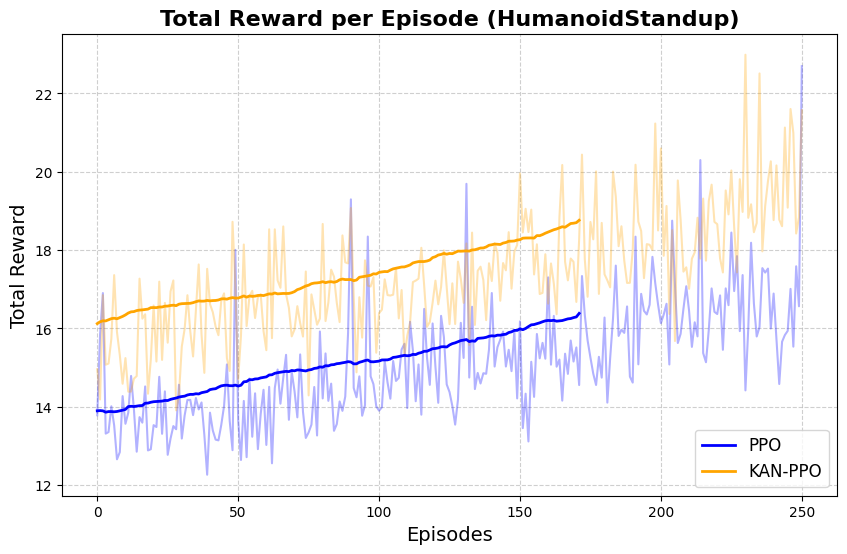

Plot saved at: comparison\HumanoidStandup_episode_scores.png


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_episode_scores(env_name, ppo_scores, kan_ppo_scores, save_dir, window_size=80):
    """
    Plots the episode scores for PPO and KAN-PPO with a smoothed trend line,
    interpolating the shorter array to match the longer one.
    
    :param env_name: Name of the environment (e.g., "CartPole-v1")
    :param ppo_scores: Array of episode scores from PPO
    :param kan_ppo_scores: Array of episode scores from KAN-PPO
    :param save_dir: Directory where the plot will be saved
    :param window_size: Moving average window for smoothing
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Determine which array is longer
    max_len = max(len(ppo_scores), len(kan_ppo_scores))
    
    # Interpolation function
    def interpolate_rewards(rewards, target_length):
        original_indices = np.linspace(0, 1, len(rewards))
        target_indices = np.linspace(0, 1, target_length)
        interp_func = interp1d(original_indices, rewards, kind="linear")  # Linear interpolation
        return interp_func(target_indices)
    
    # Interpolate the shorter array
    if len(ppo_scores) < max_len:
        ppo_scores = interpolate_rewards(ppo_scores, max_len)
    if len(kan_ppo_scores) < max_len:
        kan_ppo_scores = interpolate_rewards(kan_ppo_scores, max_len)

    episodes = np.arange(max_len)

    plt.figure(figsize=(10, 6))

    # Raw data with transparency
    plt.plot(episodes, ppo_scores, alpha=0.3, color="blue")
    plt.plot(episodes, kan_ppo_scores, alpha=0.3, color="orange")

    # Smoothed trend line
    ppo_smooth = np.convolve(ppo_scores, np.ones(window_size)/window_size, mode='valid')
    kan_ppo_smooth = np.convolve(kan_ppo_scores, np.ones(window_size)/window_size, mode='valid')

    plt.plot(np.arange(len(ppo_smooth)), ppo_smooth, label="PPO", color="blue", linewidth=2)
    plt.plot(np.arange(len(kan_ppo_smooth)), kan_ppo_smooth, label="KAN-PPO", color="orange", linewidth=2)

    # Labels and styling
    plt.xlabel("Episodes", fontsize=14)
    plt.ylabel("Total Reward", fontsize=14)
    plt.title(f"Total Reward per Episode ({env_name})", fontsize=16, fontweight="bold")
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Save figure
    save_path = os.path.join(save_dir, f"{env_name}_episode_scores.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # High-resolution for research paper
    plt.show()

    print(f"Plot saved at: {save_path}")

# Load scores from saved files
env_name = "HumanoidStandup"  # Change based on the environment

kan_ppo_scores_path = "result\\KAN-PPO\\HumanoidStandup-v5\\kscores.npy"
ppo_scores_path = "result\\PPO\\HumanoidStandup-v5\\scores1e-5.npy"

ppo_scores = np.load(ppo_scores_path)
kan_ppo_scores = np.load(kan_ppo_scores_path)

# Define save directory
save_dir = "comparison"

# Plot the scores
plot_episode_scores(env_name, ppo_scores=ppo_scores, kan_ppo_scores=kan_ppo_scores, save_dir=save_dir)


In [12]:
ppo_scores.shape, kan_ppo_scores.shape

((251,), (251,))

In [ ]:
def plot_final_performance(scores_ppo, scores_kan, last_n=100):
    """
    Plots Final Performance (Average Reward over Last N Episodes).
    """
    avg_ppo = np.mean(scores_ppo[-last_n:])
    avg_kan = np.mean(scores_kan[-last_n:])
    
    plt.figure(figsize=(7, 5))
    plt.bar(["PPO", "KAN-PPO"], [avg_ppo, avg_kan], color=['green', 'orange'])
    
    plt.xlabel("Algorithm")
    plt.ylabel("Average Reward")
    plt.title(f"Final Performance: Avg Reward over Last {last_n} Episodes")
    plt.grid(axis='y', linestyle="--", alpha=0.7)
    plt.show()


plot_final_performance(scores_ppo=ppo_scores, scores_kan=kan_ppo_scores)

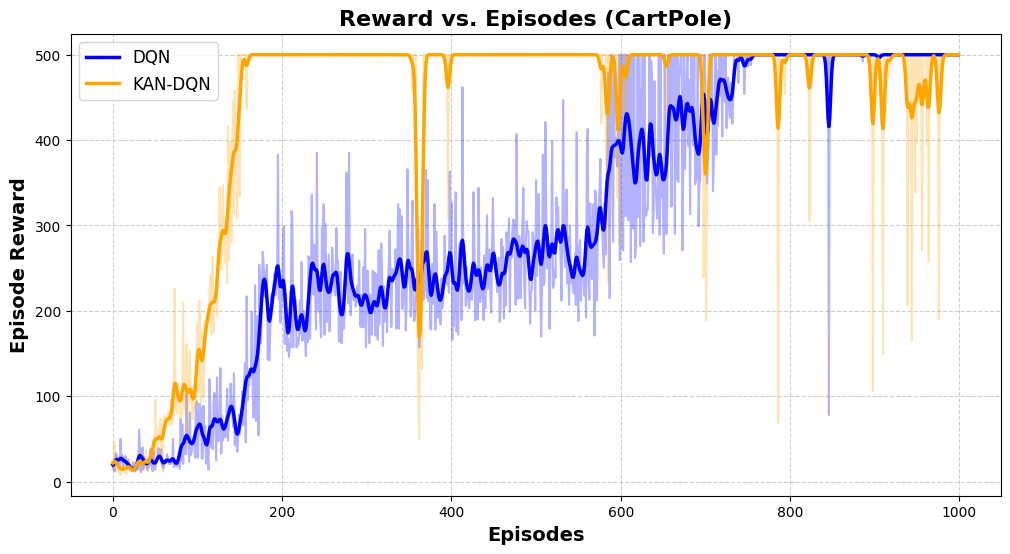

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import os
def plot_sample_efficiency(ppo_scores, kan_ppo_scores, env_name, smooth_sigma=2, save_dir='comparison'):
    """
    Plots Sample Efficiency (Reward vs. Episodes) for PPO and KAN-PPO in a research-paper format.
    
    Parameters:
        ppo_scores (np.array): Numpy array of rewards per episode for PPO.
        kan_ppo_scores (np.array): Numpy array of rewards per episode for KAN-PPO.
        env_name (str): Name of the environment (for title).
        smooth_sigma (int): Smoothing factor for Gaussian filter (higher = smoother curve).
    """

    # Define episode indices
    episodes = np.arange(len(ppo_scores))

    # Apply Gaussian smoothing
    ppo_smooth = gaussian_filter1d(ppo_scores, sigma=smooth_sigma)
    kan_ppo_smooth = gaussian_filter1d(kan_ppo_scores, sigma=smooth_sigma)

    # Create plot
    plt.figure(figsize=(12, 6))

    # Plot raw scores (light color)
    plt.plot(episodes, ppo_scores, color='blue', alpha=0.3)
    plt.plot(episodes, kan_ppo_scores, color='orange', alpha=0.3)

    # Plot smoothed curves (bold)
    plt.plot(episodes, ppo_smooth, color='blue', linewidth=2.5, label="DQN")
    plt.plot(episodes, kan_ppo_smooth, color='orange', linewidth=2.5, label="KAN-DQN")

    # Labels and title
    plt.xlabel("Episodes", fontsize=14, fontweight='bold')
    plt.ylabel("Episode Reward", fontsize=14, fontweight='bold')
    plt.title(f"Reward vs. Episodes ({env_name})", fontsize=16, fontweight='bold')

    # Grid and legend
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    save_path = os.path.join(save_dir, f"{env_name}_episode_scores.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # High-resolution for research paper
    
    # Show plot
    plt.show()

env_name = "CartPole"  # Change based on the environment

kan_ppo_scores_path = "result\\Kan-DQN\\CartPole-v1\\scores.npy"
ppo_scores_path = "result\\DQN\\CartPole-v1\\scores.npy"

ppo_scores = np.load(ppo_scores_path)
kan_ppo_scores = np.load(kan_ppo_scores_path)

plot_sample_efficiency(ppo_scores, kan_ppo_scores, env_name)


In [1]:
from agents.sac import SACAgent
import gymnasium as gym

In [3]:
gymnasium_env = ['Ant-v5', "HalfCheetah-v5", "Hopper-v5", "HumanoidStandup-v5", "Humanoid-v5", "InvertedDoublePendulum-v5", "InvertedPendulum-v5", "Reacher-v5", "Walker2d-v5"]
env = gym.make(gymnasium_env[3])

config = {
    "alpha":0.0003, 
    "beta":0.0003, 
    "input_dims":env.observation_space.shape[0], 
    "env":None, 
    "max_action":0.4, 
    "gamma":0.99, 
    "n_actions":env.action_space.shape[0], 
    "max_size":100000, 
    "tau":0.005, 
    "batch_size":256, 
    "reward_sclae":2,
    "n_layers":[128, 256, 64]
}


agent = SACAgent(config=config)

obs, _ = env.reset()

action = agent.choose_action(obs)
print(action)

[-0.16812797 -0.14288336 -0.39142656 -0.00162362  0.34731898  0.03425941
 -0.3054485   0.31612086  0.02497341 -0.2826984  -0.21676885  0.02008273
  0.3937358  -0.16362606 -0.18220714  0.25528565  0.23880015]


In [4]:
import gymnasium as gym
import gymnasium_robotics
import numpy as np

gym.register_envs(gymnasium_robotics)
env = gym.make("FetchReachDense-v3", render_mode="human")
observation, info = env.reset(seed=42)

print("Simulating with completely random actions")

# loop
summed_reward = 0
for _ in range(2000):
    action = np.random.uniform(-1, 1,4) # random action

    observation, reward, terminated, truncated, info = env.step(action) # Calculate next step of simulation.

    summed_reward += reward # sum rewards

    if terminated or truncated:
        print("summed reward =", summed_reward)
        summed_reward = 0
        observation, info = env.reset()

env.close()

Simulating with completely random actions
summed reward = -28.186513073143036
summed reward = -23.041476779060773
summed reward = -32.27496674562596
summed reward = -24.5997076879244
summed reward = -38.03859009449719
summed reward = -28.782057914661724
summed reward = -29.208122752263336
summed reward = -31.42928610080723
summed reward = -28.945937909235962
summed reward = -15.19180751084433
summed reward = -42.44741014238728
summed reward = -31.240267410990743
summed reward = -29.693816261042677
summed reward = -23.374546433631725
summed reward = -23.208614035201734
summed reward = -29.3069416488908
summed reward = -35.65284032140504
summed reward = -28.135691425262674
summed reward = -32.840837586172945
summed reward = -30.145929081021958
summed reward = -29.397237139996676
summed reward = -28.273194221960942
summed reward = -31.82829940078422
summed reward = -23.25013730552992
summed reward = -31.070164572200973
summed reward = -25.996473644834253
summed reward = -28.56610771866987

c:\ProgramData\Anaconda3\envs\gymnasium-linux\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


summed reward = -10.733685016816915
summed reward = -20.88999694494829
summed reward = -30.0669045049928
summed reward = -26.396181320036003
summed reward = -20.898314072066096
summed reward = -29.73347499749952
summed reward = -34.222399080830215
summed reward = -31.046036902076324
summed reward = -32.75378748359922
summed reward = -25.96985536947442
summed reward = -32.021616521486266
summed reward = -32.59689721816447


In [2]:
from robotic_agent.sac import SAC
import datetime
import gymnasium as gym
import numpy as np
import itertools
import torch
from tqdm import tqdm

In [3]:


# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v5",
    "policy": "Gaussian",
    "eval": True,
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.2,
    "automatic_entropy_tuning": False,
    "seed": 123456,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": False
}

# Environment
env = gym.make(config["env_name"])

torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

In [10]:
print(100*'=')

In [ ]:
import gymnasium as gym
import panda_gym

env = gym.make('PandaReach-v3', render_mode="human")

observation, info = env.reset()

for _ in range(10):
    action = env.action_space.sample() # random action
    observation, reward, terminated, truncated, info = env.step(action)
    print(observation)
    if terminated or truncated:
        observation, info = env.reset()
